# Import

In [34]:
# Numpy
import numpy as np
# Beta-binomial distribution
from scipy.special import beta as beta_func
from scipy.misc import comb
def beta_binomial(n, alpha, beta):
    return [comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta) for k in range(n)]
# Numerical integration
from scipy.integrate import odeint
# Plotting
% matplotlib inline
from matplotlib import pyplot as plt

# Utility functions

In [35]:
# Define the utility functions
def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
    #return 1 - abs(action - state - (1-state)*b)
def U_R(state, action):
    return 1 - (action - state)**2
# Define functions to map integers to interval [0,1]
def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

# Payoff matrices

In [230]:
# Create payoff matrices 
print "Sender payoff matrix"
number = 3
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), 1) for j in range(number)] for i in range(number)])
print A
print "Receiver payoff matrix"
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
print B

Sender payoff matrix
[[ 0.    0.75  1.  ]
 [ 0.    0.75  1.  ]
 [ 0.    0.75  1.  ]]
Receiver payoff matrix
[[ 1.    0.75  0.  ]
 [ 0.75  1.    0.75]
 [ 0.    0.75  1.  ]]


# Population matrices

In [164]:
# Import random and set seed
import random
random.seed(10)
# Create initial sender matrix
X = np.random.rand(3, 2)
# Row-normalize the sender matrix
X /= X.sum(axis=1)[:,np.newaxis]
print X
# Create initial receiver matrix
Y = np.random.rand(2, 3)
# Row-normalize the receiver matrix
Y /= Y.sum(axis=1)[:,np.newaxis]
print Y

[[ 0.7005261   0.2994739 ]
 [ 0.38189947  0.61810053]
 [ 0.4194224   0.5805776 ]]
[[ 0.32444684  0.51451344  0.16103972]
 [ 0.18080972  0.34712311  0.47206717]]


# Prior probability distribution

In [30]:
P = np.matrix((beta_binomial(3, 1, 2) * 3)).reshape(3,3)
print P

[[ 0.5         0.33333333  0.16666667]
 [ 0.5         0.33333333  0.16666667]
 [ 0.5         0.33333333  0.16666667]]


# Sender expected utility

In [31]:
print "Sender expected utility"
print A * Y.transpose()

Sender expected utility
[[ 0.56636014  0.40672054]
 [ 0.81450223  0.78348312]
 [ 0.56264431  0.66024571]]


In [32]:
print "Average sender expected utility"
print (X * (A * Y.transpose()).transpose()).diagonal()

Average sender expected utility
[[ 0.48716071  0.80251973  0.56458409]]


In [33]:
np.subtract(A * Y.transpose(),  (X * (A * Y.transpose()).transpose()).diagonal().transpose())

matrix([[ 0.07919943, -0.08044017],
        [ 0.0119825 , -0.0190366 ],
        [-0.00193978,  0.09566161]])

In [52]:
np.multiply(X, np.subtract(A * Y.transpose(),  (X * (A * Y.transpose()).transpose()).diagonal().transpose()))

matrix([[ 0.03990749, -0.03990749],
        [ 0.00735373, -0.00735373],
        [-0.00190123,  0.00190123]])

# Receiver expected utility

In [46]:
print X

[[ 0.50388606  0.49611394]
 [ 0.61370579  0.38629421]
 [ 0.98012551  0.01987449]]


In [45]:
print P
print P.transpose()[:,0:2]
print "Conditional probability of t_i given message m_j"
C = np.divide(np.multiply(P.transpose()[:,0:2], X), P * X)
print C

[[ 0.5         0.33333333  0.16666667]
 [ 0.5         0.33333333  0.16666667]
 [ 0.5         0.33333333  0.16666667]]
[[ 0.5         0.5       ]
 [ 0.33333333  0.33333333]
 [ 0.16666667  0.16666667]]
Conditional probability of t_i given message m_j
[[ 0.40644765  0.65255118]
 [ 0.33002074  0.33873502]
 [ 0.26353161  0.00871381]]


In [47]:
print "Receiver expected utility"
print (B.transpose() * C)
print "Receiver expected utility of responding to m_i with a_j"
print (B.transpose() * C).transpose()

Receiver expected utility
[[ 0.65396321  0.90660244]
 [ 0.83250518  0.83468375]
 [ 0.51104716  0.26276507]]
Receiver expected utility of responding to m_i with a_j
[[ 0.65396321  0.83250518  0.51104716]
 [ 0.90660244  0.83468375  0.26276507]]


In [48]:
print "Average receiver expected utility"
print (Y * (B.transpose() * C)).diagonal()

Average receiver expected utility
[[ 0.64727294  0.53655239]]


In [49]:
np.subtract((B.transpose() * C).transpose(), (Y * (B.transpose() * C)).diagonal().transpose())

matrix([[ 0.00669027,  0.18523225, -0.13622577],
        [ 0.37005005,  0.29813137, -0.27378732]])

In [75]:
Y_diff = np.multiply(Y, np.subtract((B.transpose() * C).transpose(), (Y * (B.transpose() * C)).diagonal().transpose()))
print Y_diff
print Y_diff[0,0]

[[ 0.00249449  0.04779157 -0.05028606]
 [ 0.11333566  0.03992948 -0.15326514]]
0.00249449130602


In [269]:
def signaling(p_vec, t):
    # Unpack the position vector
    X = p_vec[0:6].reshape(3,2)
    Y = p_vec[6:].reshape(2,3)
    # Calculate sender growth rates
    X_diff = np.multiply(X, np.subtract(A * Y.transpose(),  (X * (A * Y.transpose()).transpose()).diagonal().transpose()))
    # Calculate receiver growth rates
    C = np.divide(np.multiply(P.transpose()[:,0:2], X), P * X)
    Y_diff = np.multiply(Y, np.subtract((B.transpose() * C).transpose(), (Y * (B.transpose() * C)).diagonal().transpose()))
    # Construct system of ODEs
    x00_diff = X_diff[0,0]
    x01_diff = X_diff[0,1]
    
    x10_diff = X_diff[1,0]
    x11_diff = X_diff[1,1]
    
    x20_diff = X_diff[2,0]
    x21_diff = X_diff[2,1]
    
    y00_diff = Y_diff[0,0]
    y01_diff = Y_diff[0,1]
    y02_diff = Y_diff[0,2]

    y10_diff = Y_diff[1,0]
    y11_diff = Y_diff[1,1]
    y12_diff = Y_diff[1,2]
    
    # Return system of ODEs
    return [x00_diff, x01_diff,\
            x10_diff, x11_diff,\
            x20_diff, x21_diff,\
            y00_diff, y01_diff, y02_diff,\
            y10_diff, y11_diff, y12_diff]

In [113]:
from __future__ import division

# Wallage data 

In [273]:
t_output = np.linspace(0, 20, num=100)
# Create payoff matrices 
number = 3
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), 1) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])

# Counts from Wallage (2013) for states and messages from 1150-1250
W = np.matrix([[335, 58], [33, 170], [15, 37]])
#W_full = np.array([[335, 57, 1],[15, 37, 0], [33, 168, 2]]) # distinguishes ne..not from not
row_sums = W.sum(axis=1)
X = W / row_sums # Probability of message m_j in state t_i
C = np.divide(np.multiply(P.transpose()[:,0:2], X), P * X) # Probability of state t_i given message m_j
Y = C.transpose()
#print X
#print Y
#print X.flatten().shape
#print Y.flatten().shape

#print np.concatenate([X.ravel().transpose(), Y.ravel().transpose()]).flatten()
p0_vec = np.asarray(np.concatenate([X.ravel(), Y.ravel()], axis=1))[0]
#p0_vec = np.concatenate([X.ravel(), Y.ravel()])
#print p0_vec

In [274]:
p_vec_result = odeint(signaling, p0_vec, t_output)

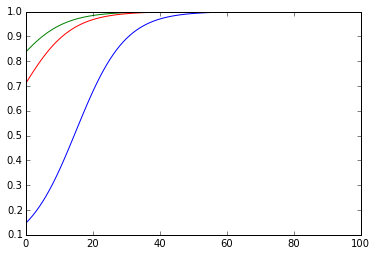

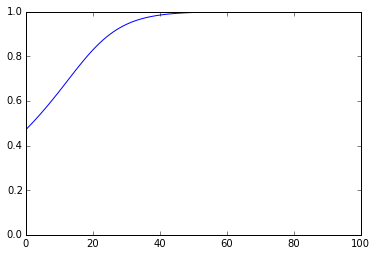

In [275]:
senders = p_vec_result[:,:6]
senders_nenot = p_vec_result[:,[1,3,5]]

plt.plot(senders_nenot)
#plt.plot(p_vec_result[:,2])
#plt.plot(p_vec_result[:,4])
plt.show()
plt.plot(senders_nenot * P.transpose()[:,0])
plt.ylim(0,1)
plt.show()
#plt.plot(p_vec_result[:,6])
#plt.plot(p_vec_result[:,7])
#plt.plot(p_vec_result[:,9])
#plt.plot(p_vec_result[:,10])
#plt.show()


## Stipulated distributions

In [363]:
def signaling_n(p_vec, t):
    # Unpack the position vector
    X = p_vec[:20].reshape(10,2)
    Y = p_vec[20:].reshape(2,10)
    # Calculate sender growth rates
    X_diff = np.multiply(X, np.subtract(A * Y.transpose(),  (X * (A * Y.transpose()).transpose()).diagonal().transpose()))
    # Calculate receiver growth rates
    C = np.divide(np.multiply(P.transpose()[:,0:2], X), P * X)
    Y_diff = np.multiply(Y, np.subtract((B.transpose() * C).transpose(), (Y * (B.transpose() * C)).diagonal().transpose()))
    # Construct system of ODEs
    x00_diff = X_diff[0,0]
    x01_diff = X_diff[0,1] 
    x10_diff = X_diff[1,0] #
    x11_diff = X_diff[1,1]
    x20_diff = X_diff[2,0] #
    x21_diff = X_diff[2,1]
    x30_diff = X_diff[3,0] #
    x31_diff = X_diff[3,1] 
    x40_diff = X_diff[4,0] #
    x41_diff = X_diff[4,1]
    x50_diff = X_diff[5,0] #
    x51_diff = X_diff[5,1]
    x60_diff = X_diff[6,0]
    x61_diff = X_diff[6,1]
    x70_diff = X_diff[7,0]
    x71_diff = X_diff[7,1]
    x80_diff = X_diff[8,0]
    x81_diff = X_diff[8,1]
    x90_diff = X_diff[9,0]
    x91_diff = X_diff[9,1]
        
    y00_diff = Y_diff[0,0]
    y01_diff = Y_diff[0,1]
    y02_diff = Y_diff[0,2]
    y03_diff = Y_diff[0,3]
    y04_diff = Y_diff[0,4]
    y05_diff = Y_diff[0,5]
    y06_diff = Y_diff[0,6]
    y07_diff = Y_diff[0,7]
    y08_diff = Y_diff[0,8]
    y09_diff = Y_diff[0,9]

    y10_diff = Y_diff[1,0]
    y11_diff = Y_diff[1,1]
    y12_diff = Y_diff[1,2]
    y13_diff = Y_diff[1,3]
    y14_diff = Y_diff[1,4]
    y15_diff = Y_diff[1,5]
    y16_diff = Y_diff[1,6]
    y17_diff = Y_diff[1,7]
    y18_diff = Y_diff[1,8]
    y19_diff = Y_diff[1,9]
    
    # Return system of ODEs
    return [x00_diff, x01_diff,\
            x10_diff, x11_diff,\
            x20_diff, x21_diff,\
            x30_diff, x31_diff,\
            x40_diff, x41_diff,\
            x50_diff, x51_diff,\
            x60_diff, x61_diff,\
            x70_diff, x71_diff,\
            x80_diff, x81_diff,\
            x90_diff, x91_diff,\
            y00_diff, y01_diff, y02_diff, y03_diff, y04_diff, y05_diff, y06_diff, y07_diff, y08_diff, y09_diff,\
            y10_diff, y11_diff, y12_diff, y13_diff, y14_diff, y15_diff, y16_diff, y17_diff, y18_diff, y19_diff]

In [575]:
t_output = np.linspace(0, 100, num=100)

number = 10
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), .3) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])

P = np.matrix((beta_binomial(10, 1, 2) * 10)).reshape(10,10)

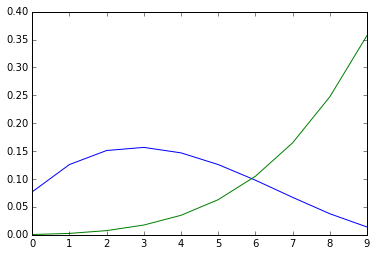

[[ 0.7992893  0.2007107]]


In [576]:
alpha1 = 2
beta1 = 3
alpha2 = 5
beta2 = 1

plt.plot(beta_binomial(10, alpha1, beta1))
plt.plot(beta_binomial(10, alpha2, beta2))
plt.show()

X = np.matrix([beta_binomial(10, alpha1, beta1), beta_binomial(10, alpha2, beta2)]).transpose()
row_sums = X.sum(axis=1)
X = X / row_sums
#X = np.matrix([1 - np.arange(1/11.0, 1, step=1/11.0), np.arange(1/11.0, 1, step=1/11.0)]).transpose()
#X = np.matrix([beta_binomial(11, 1, 2), np.subtract([1] * 11, beta_binomial(11, 1, 2))]).transpose()
C = np.divide(np.multiply(P.transpose()[:,0:2], X), P * X) # Probability of state t_i given message m_j
Y = C.transpose()

p0_vec = np.asarray(np.concatenate([X.ravel(), Y.ravel()], axis=1))[0]


print P[0,:] * X

In [577]:
p_vec_result = odeint(signaling_n, p0_vec, t_output)

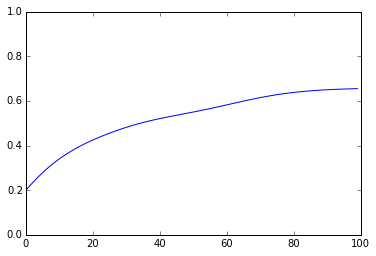

In [579]:
senders_nenot = p_vec_result[:,[1,3,5,7,9,11,13,15,17,19]]
plt.plot(senders_nenot * P.transpose()[:,0])
plt.ylim(0,1)
plt.show()

## Iterated changes

In [ ]:
t_star = 